In [185]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import data_gen as dg

import torch
import geomloss

import matplotlib.pyplot as plt

# general situation for gaussian inference

In [186]:
def generate_gaussian_params(d, sigma_mu=0.1, sigma_cov=0.1, seed=0):
    torch.manual_seed(seed)
    
    mu = sigma_mu * torch.randn(d)

    A = sigma_cov * torch.randn(d, d)
    cov = A @ A.T + 1e-2 * torch.eye(d)

    return mu, cov

def generate_gaussian_data(mu, cov, n_samples, seed=0):
    torch.manual_seed(seed)

    L = torch.linalg.cholesky(cov)
    d = mu.shape[0]

    z = torch.randn(n_samples, d)
    samples = mu + z @ L.T

    return samples

In [187]:
def potential_grad(samples, mu, cov):

    diff = samples - mu
    precision = torch.linalg.inv(cov)

    grad = torch.linalg.solve(cov, diff.T).T
    return grad

In [188]:
def evolve_langevin(samples, mu, cov, eps=1e-2, n_evolution=1, seed=0):

    torch.manual_seed(seed)
    evolved_samples = samples.clone()

    for i in range(n_evolution):
        grad = potential_grad(evolved_samples, mu, cov)
        noise = torch.randn_like(evolved_samples)
        evolved_samples = evolved_samples - eps * grad + torch.sqrt(torch.tensor(2 * eps)) * noise

    return evolved_samples

In [189]:
sinkhorn_loss = geomloss.SamplesLoss(loss="sinkhorn", p=2, blur=0.05)

def lm_loss(samples, mu, cov):

    evolved_samples = evolve_langevin(samples, mu, cov)

    return sinkhorn_loss(samples, evolved_samples)

In [ ]:
def plot_distributions(samples, evolved, epoch):
    d = samples.shape[1]

    plt.figure(figsize=(6, 5))

    if d == 1:
        samples_np = samples.cpu().numpy().flatten()
        evolved_np = evolved.cpu().numpy().flatten()
        plt.hist(samples_np, bins=50, alpha=0.5, label='Original', density=True)
        plt.hist(evolved_np, bins=50, alpha=0.5, label='Evolved', density=True)
        plt.xlabel("x")

    elif d == 2:
        samples_np = samples.cpu().numpy()
        evolved_np = evolved.cpu().numpy()
        plt.scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.3, label='Original', s=10)
        plt.scatter(evolved_np[:, 0], evolved_np[:, 1], alpha=0.3, label='Evolved', s=10)
        plt.xlabel("x1")
        plt.ylabel("x2")

    else:
        print(f"plot not implemented for dimension d = {d}")
        return

    plt.legend()
    plt.title(f"epoch {epoch}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [191]:
def lm_optimize(samples, n_epochs=1000, lr=1e-2, seed=10, eps=1e-2, n_evolution=10, plot_every=500):

    d = samples.shape[1]
    torch.manual_seed(seed)

    mu = torch.randn(d, requires_grad=True)
    a = torch.randn(d, d, requires_grad=True)

    optimizer = torch.optim.Adam([mu, a], lr=lr)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        cov = a.T @ a
        loss = lm_loss(samples, mu, cov)
        loss.backward()
        optimizer.step()

        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss.item():.6f} | mean = {mu} | cov = {cov}")
            with torch.no_grad():
                evolved_samples = evolve_langevin(samples, mu, cov)
                plot_distributions(samples, evolved_samples, epoch)

    return mu.detach(), cov.detach()

tensor([15.4100, -2.9343]) 

 tensor([[20.2909,  6.2718],
        [ 6.2718, 12.5390]]) 




epoch 0 | loss = 0.034211 | mean = tensor([-0.5914, -1.0222], requires_grad=True) | cov = tensor([[0.9375, 0.0506],
        [0.0506, 1.6286]], grad_fn=<MmBackward0>)


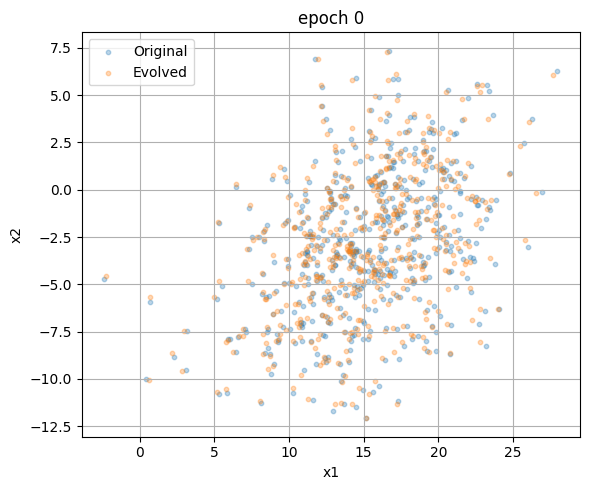

In [ ]:
d = 2
mu_true, cov_true = generate_gaussian_params(d, sigma_mu=10, sigma_cov=2, seed=0)
samples = generate_gaussian_data(mu_true, cov_true, n_samples=500, seed=1)
print(mu_true, "\n\n", cov_true, "\n\n\n\n")

mu_hat, cov_hat = lm_optimize(samples, n_epochs=15000, lr=1e-2)

print("\n--------- results: ---------")
print("mu true:     ", mu_true)
print("mu hat:  ", mu_hat)
print("cov true:\n", cov_true)
print("cov hat:\n", cov_hat)